# Time Series Analysis

By definition, a time series is a sequence of observations that are recorded at regular time intervals. We analyze time series and build time series models to forecast future values of the target variable based on time, i.e. how previous historical target variable values affect the future target variable values.

In [ ]:
# We usually want time as the index of the DataFrame

import pandas as pd

df = pd.read_csv("file.csv", index_col="time", parse_dates=[0]) # parse_dates to ensure that index is datetime object

In [ ]:
# To graph a time series, we can simply plot the series data, as long as the index of series is time

from matplotlib import pyplot as plt

plt.plot(df['y_value'])

In [ ]:
# We can graph the trend of the time series by grouping the data by month, year, etc. We can graph them using box plots or
# line graphs

def create_df(column, value, df):
    return df.loc[df[column] == value]

hour = [i for i in range(24)]
hour_df = []

for i in range(24):
    hour_df.append(create_df('Hour', i, df))

plt.boxplot(hour_df, labels=hour)

A time series can be split into different components: a base level, a trend, seasonality, and the error/residual term. The trend of a time series is an increase or decrease over a period of time, and the seasonality of the time series is defined to be a pattern of increasing or decreasing values that is reoccuring due to seasonal events. A time series may also have a cyclic behaviour, which is when the rise and fall patterns occur not in fixed calendar-based intervals. Usually, cyclic behaviour occurs due to business or socio economic factors, and not due to seasonal events. 

To split the time series into those different components, we model the time series either as an additive or a multiplicative time series, based on the following formulas: $$avalue = base level + trend + seasonality + error$$ $$mvalue = base level * trend * seasonality * error$$

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Multiplicative Decomposition, extrapolate_trend='freq' to deal with missing timed values, period=365*24 signifying 
# time series is hourly 
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq', period=365 * 24)

# Additive Decomposition
result_add = seasonal_decompose(df['value'], model='additive', extrapolate_trend='freq', period=365 * 24)

# Plot
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [ ]:
# Decomposed multiplicative time series in DataFrame

df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

### Impute Missing Values in Time Series

If we have missing values in our time series dataset, there are a couple of ways to impute these values. Using the mean and median is not recommended as this discounts the trend and seasonality of the dataset. Thus, we can either use forward fill, backwards fill, or we can use interpolation techniques such as linear and spline interpolation.

In [ ]:
# Forward fill, backwards fill
df['value'] = df['value'].fillna(method='ffill')
df['value'] = df['value'].fillna(method='bfill')

# Linear interpolation, spline interpolation
df['value'] = df['value'].interpolate(method='linear')
df['value'] = df['value'].interpolate(method='spline')

### Stationary and Non-Stationary Time Series

Stationarity is a property of time series. It follows that we would rather work with stationary time series, as many models are built around that property, since it is easier to predict future values with these types of time series. This is because in regression analysis, it follows that the values of the independent variable, whether categorical or quantitative, must be independent of each other in order for the analysis to be effective. This assumption holds for time series, where the lags must be independent of the current values. A stationary time series is a time series where the mean value stays constant throughout the series, has no occurance of seasonality(variance is constant), and its autocorrelation is constant(previous values has constant correlation with current values).

However, most time series will be non-stationary, thus we need to make the time series stationary in order for the time series to work in models. A common method to stationarize the series is through differencing the series until it becomes approximately stationary. So, we create a function $Z_t$, and define is as the difference between the current value and the previous value of lag 1: $Z_t = Y_t - Y_{t-1}$. If after the first differencing does not make the time series stationary, then we take the second difference $W_t$ such that $W_t = Z_t - Z_{t-1}$.

To test for stationarity quantitatively, we use unit root tests, such as the ADFuller test, the KPSS test, and the PP test. In the ADFuller test, it follows that the null hypothesis states that the series possesses a unit root, thus if the p-value is less than 0.05, then we reject the null hypothesis and conclude that the time series is stationary. The KPSS test, however, has an opposite null hypothesis, where it states that the series is trend stationary, meaning that the series is stationary around the trend. The trend of a trend stationary time series can also be called a deterministic trend, and we can simply remove the trend from the series to get a stationary series. Thus, if the p-value is less than 0.05, then we reject the null hypothesis and conclude that the time series is non-stationary(it has a unit root).

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADFuller Test
result = adfuller(df['value'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
    
# KPSS Test
result = kpss(df['value'])
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

There are four cases when getting results from these tests.

Case 1: If both tests infer that the series is not stationary, then it is not stationary

Case 2: If both tests infer that the series is stationary, then it is stationary

Case 3: If KPSS infers that series is stationary and ADFuller infers that series is non-stationary, then this means that the series has a deterministic trend, meaning that we simply have to remove the trend to stationalize the time series

Case 4: If KPSS infers that series is non-stationary and ADFuller infers that series is stationary, then this means that the series is difference stationary, or has a stochastic trend, meaning that we can stationalize the series by differencing the series with respect to the degree D(the number of times to difference the time series)

### Detrend Time Series

To detrend the time series, we must know if the trend we are dealing with is deterministic or stochastic. If it is deterministic, then we simply subtract the trend from the time series either by subtracting the line of best fit, or the trend component derived from the time series decomposition.

In [ ]:
# Subtract the line of best fit
from scipy import signal

detrended = signal.detrend(df['value'])
plt.plot(detrended)

# Subtract the trend component from the series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

detrended = df['value'] - result_mul.trend # result_add.trend if using multiplicative time series decomposition
plt.plot(detrended)

If time series contains stochastic trend, then we apply differencing to the time series with respect to degree D.

In [ ]:
# Difference with degree 1

df['value_diff'] = df['value'] - df['value'].shift(1)
plt.plot(df['value_diff'])

# Another method, difference with degree 2

plt.plot(df['value'].diff().diff().dropna())

### Deseasonalize Time Series

There are a couple ways to deseasonalize time series. We can take a moving average in the seasonal time period, which will also smoothen the time series, we can take the seasonal difference, meaning that we subtract the current value from the previous season value, or we can divide the series by the seasonal values obtained from the time series decomposition. If we cannot divide the seasonal values, we can take the log of the series first, then we divide the seasonal values, then we restore towards the original scale by taking the exponential.

In [ ]:
# Divide the series by the seasonal values from the time series decomposition

deseasonalized = df['value'] / result_mul.seasonal # result_add.seasonal if using additive time series decomposition
plt.plot(deseasonalized)

### Auto Correlation and Partial Auto Correlation Functions

To identify which lags have significant correlations, or to understand better the patterns of the time series, or to assess the randomness or stationarity of the series, or to determine trends and seasonal patterns, we use an autocorrelation function. An autocorrelation function(ACF) calculates the correlation between current points on the time series with previous lags. Thus, if we calculate the autocorrelation of lag 1, then we calculate the correlation between the current point and the previous point. If the absolute value of the correlation is higher than the statistically significant threshold, then it follows that there is a significant correlation between that particular lag and the current point. If the correlation is lower, then it follows that the value related to its lag is random.

Partial autocorrelation functions are different from autocorrelation functions in the sense that PACFs calculate the direct correlation between the lag and the current value, disregarding the indirect correlations in between the lag and the current value, which the ACF considers indirect correlations. 

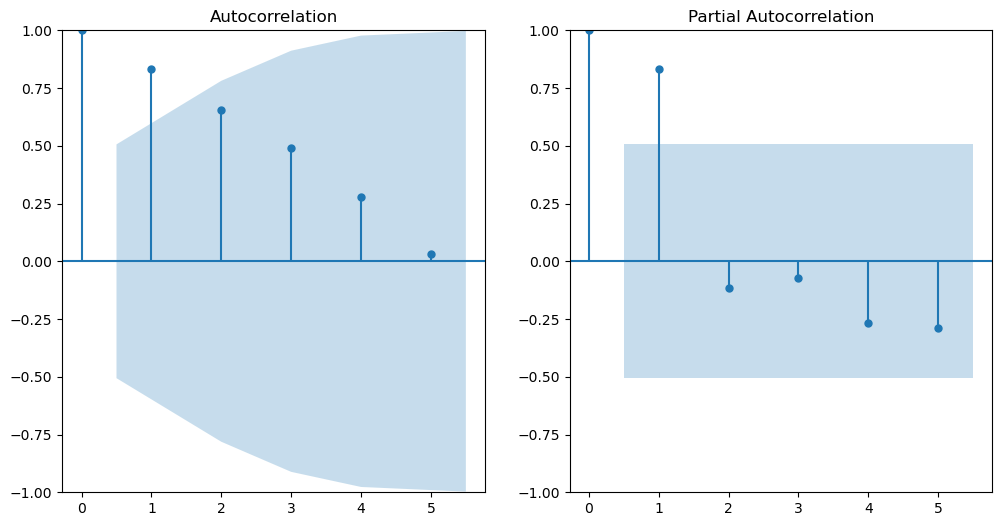

In [11]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Graph acf and pacf functions

fig, axes = plt.subplots(1,2,figsize=(12, 6))
x = [22, 24, 25, 25, 28, 29, 34, 37, 40, 44, 51, 48, 47, 50, 51]
plot_acf(x, lags=5, ax=axes[0])
plot_pacf(x, lags=5, ax=axes[1])
plt.show()